In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math

from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set the main device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VQ-VAE
We want to create a VQ-VAE class. This is used to embed the input data x into a more comprehensible embedding e with shape [K, d], where K is the number of embeddings and d is the dimension of the embedding. More intuitively we have K embeddings of size d. This follows the notation in figure 1 https://arxiv.org/abs/1711.00937. The code is inspired by the guide from Huggingface, but adapted for the task at hand https://huggingface.co/blog/ariG23498/understand-vq.

# Computation
A common metric is the Mean Squared Error (MSE) loss. Adapting to a vector $z$ with the embedding $z_q$ we can formulate it as $$MSE = \frac{1}{N}\sum{(z_i-z_{q_i})^2}$$ over all elements $N$. Using reformulation by the square of the sum we can write this as $$MSE =\frac{1}{N}\sum{{z_i}^2+{z_{q_i}}^2-2*z_i*z_q}$$ which we implement by dividing it in three summation parts and using a flattened z for easier calculation. We ignore the constant N as it doesn't affect the minimal index that we want to return.

In [5]:
class VQEmbedding(nn.Module):
    def __init__(self, num_emb, emb_dim, B = 0.25):
        super().__init__()
        # Note that num_emb = K, emb_dim = D
        # B is the commitment loss assuring that the encoder commits to an embedding (p. 4)
        self.emb_dim = emb_dim
        self.num_emb = num_emb

        # Initialize an embedding table and fill it with uniform values with expected mean = 0
        self.embedding = nn.Embedding(num_emb, emb_dim) # codebook of size [K, D]
        self.embedding.weight.data.uniform_(-1/self.num_emb, 1/self.num_emb)
        self.B = B

    def forward(self, z_e):
        # Take the input z_e from the encoder and add it to the embedding
        b,c,h,w = z_e.shape
        z_bhwc = z_e.permute(0,2,3,1) # Reformat by moving channel to the end

        # Flatten the z into a [b*h*w, emb_dim] vector
        z_flattened = z_bhwc.reshape(b*h*w, self.emb_dim)
        # Note: e = self.embedding.weight

        # Calculate the distance using ||a-b||
        dist = (torch.sum(z_flattened**2, -1, keepdim=True) +
               torch.sum(self.embedding.weight.t()**2, dim=0,keepdim=True) -
               2*torch.matmul(z_flattened, self.embedding.weight.t())
        )
        # We want to minimize the loss (page 3 in the paper)
        enc_idx = dist.argmin(dim = -1)

        # out shape : [b*h*w, emb_dim] (idx in the embedding)
        z_q = self.embedding(enc_idx)
        z_q = z_q.reshape(b,h,w,self.emb_dim)
        # Going from [b,h,w,emb_dim]->[b,emb_dim,h,w] to match input
        z_q = z_q.permute(0, 3, 1, 2)

        # Trick to counteract that the embedding is non-differentiable
        # This is the L on page 4 (TODO: explain these steps better!)
        reconstruction_loss = F.mse_loss(z_q, z_e.detach())
        commitment_loss = self.B*F.mse_loss(z_q.detach(), z_e)
        loss = reconstruction_loss + commitment_loss

        z_q = z_e + (z_q - z_e).detach()

        # z_q shape is [b,emb_dim,h,w]
        return z_q, loss, enc_idx

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.residual = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1, stride=1),
        )

    def forward(self, x):
        return x + self.residual(x)

In [ ]:
class VQEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels = 256):
        # We need to form a [ze_(x),D] object (see p. 4)
        # Inspired by p. 5
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels,
                               kernel_size = 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels,
                               kernel_size = 4, stride = 2, padding = 1)

        self.activation = nn.ReLU()

        # We create two residual blocks as in the paper (p. 5)
        self.res_blocks = nn.ModuleList([
            ResidualBlock(hidden_channels, ),
            ResidualBlock(hidden_channels)
        ])

    def forward(self, x):
        # Encoder consisits of 2 convolutional layer followed by residual blocks
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        for f in self.res_blocks:
            x = f(x)
        # [B, hidden_channels, H, W]
        return x

class VQDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Use in_channels = emb_dim

        self.res_blocks = nn.ModuleList([
            ResidualBlock(in_channels),
            ResidualBlock(in_channels)
        ])
        # Small change

        self.deconv1 = nn.ConvTranspose2d(in_channels, in_channels,
                                          kernel_size=4, stride = 2, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels, out_channels,
                                          kernel_size=4, stride = 2, padding = 1)

        self.activation1 = nn.ReLU()
        self.activation2 = nn.Sigmoid()

    def forward(self, z):
        for f in self.res_blocks:
            z = f(z)
        x = self.deconv1(z)
        x  = self.activation1(x)
        x = self.deconv2(x)
        x = self.activation2(x)
        return x

In [ ]:
class VQVAE(nn.Module):
    def __init__(self, in_channels, hidden_dim, K, B = 0.4):
        super().__init__()
        self.encoder = VQEncoder(in_channels, hidden_dim)
        self.embedding = VQEmbedding(K, hidden_dim, B = B)
        self.decoder = VQDecoder(hidden_dim, in_channels)

    def forward(self, x):
        z = self.encoder(x)
        z_q, emb_loss, enc_idx = self.embedding(z)
        x_hat = self.decoder(z_q)

        return x_hat, emb_loss, enc_idx

## Load dataset for testing

In [ ]:
def load_cifar():
    data_dir = "./data"

    # Get dataset
    transform = transforms.ToTensor()
    train_set = CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    N = len(train_set)

    # Set a suitable batch size
    batch_size = 128

    # Create data loader
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    return train_loader

In [16]:
import quixdata as quix
import torchvision.transforms as T

datapath = "./data/"
in_mean = [0.485, 0.456, 0.406]
in_std = [0.229, 0.224, 0.225]

postprocess = (T.Compose([T.ToTensor(), T.Normalize(in_mean, in_std)]), 
               T.ToTensor())

data = quix.QuixDataset(
    "CarRecs", 
    datapath, 
    override_extensions = [
        'jpg',
        'scores.npy'
    ]
).map_tuple(*postprocess)

#with traindata.shufflecontext():
N = len(data)

# Set a suitable batch size
batch_size = 128

# Create data loader
train_loader = DataLoader(data, shuffle=True, batch_size=batch_size, num_workers = 4)
x0, y0 = data[0]

names = ["Raof", "Moira", "Louie", "Ferdinando", "Gragar", "Esther"]

In [17]:
vq_model = VQVAE(in_channels = 3, hidden_dim = 256, K = 512).to(device)
lr = 3e-4

optimizer = Adam(vq_model.parameters(), lr = lr)
epochs = 15

vq_model.train()
results = []
for epoch in range(epochs):
    train_bar = tqdm(iterable = train_loader)
    for x, c in train_bar:
        x = x.to(device, non_blocking = True)
        #c = c.to(device, non_blocking = True)

        optimizer.zero_grad(set_to_none=True)
        x_hat, emb_loss, enc_idx = vq_model(x)

        reconstruction_loss = F.mse_loss(x_hat, x, reduction = "mean")
        loss = reconstruction_loss + emb_loss

        loss.backward()
        optimizer.step()

        train_bar.set_description(f'Epoch [{epoch+1}/{epochs}]')
        train_bar.set_postfix(
            emb_loss = f"{emb_loss.item():.3f}",
            total_loss = f"{loss.item():.3f}"
            )
    # Store a few results for visualization
    with torch.no_grad():
        x, x_hat = x[0].detach().cpu(), x_hat[0].detach().cpu()
        results.append({"epoch" : epoch, "x" : x, "x_hat" : x_hat})

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch [15/15]: 100%|██████████| 47/47 [09:03<00:00, 11.55s/it, emb_loss=1.508, total_loss=2.461]


In [22]:
# After training
torch.save(vq_model.state_dict(), "vq_model.pth")

# Test the VQ-Embedding model

In [20]:
def normalize_img(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

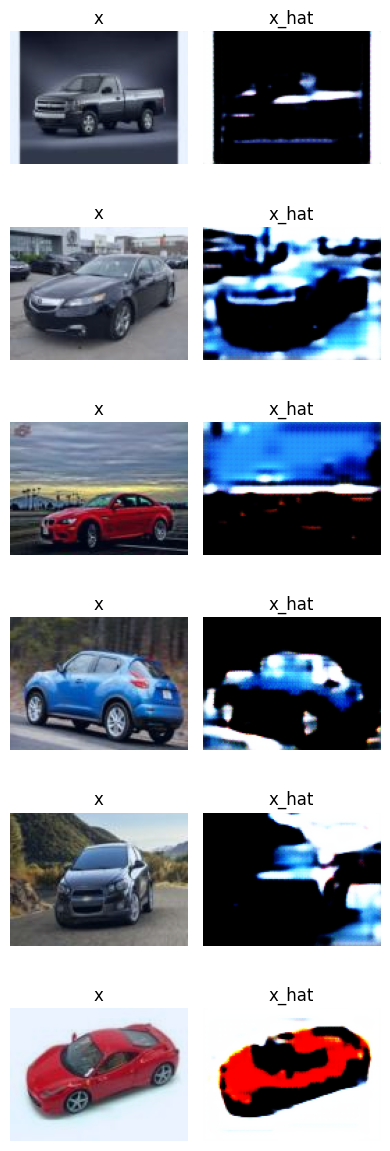

In [21]:
# Code written by GPT-5
def show_recon_pairs(results, n=8):
  results = results[-n:]
  n = min(n, len(results))
  fig, axes = plt.subplots(n, 2, figsize=(4, 2*n))
  if n == 1:
      axes = [axes]  # make it iterable
  for i in range(n):
      x = results[i]["x"]
      x_hat = results[i]["x_hat"]

      # Detect color vs grayscale
      if x.dim() == 3 and x.shape[0] == 3:
          # RGB path
          axes[i][0].imshow(normalize_img(x).permute(1,2,0).numpy())
          axes[i][1].imshow(normalize_img(x_hat).permute(1,2,0).numpy())
      else:
          # Grayscale path
          axes[i][0].imshow(x.squeeze().numpy(), cmap="gray")
          axes[i][1].imshow(x_hat.squeeze().numpy(), cmap="gray")
      axes[i][0].set_title("x")
      axes[i][0].axis("off")
      axes[i][1].set_title("x_hat")
      axes[i][1].axis("off")
  plt.tight_layout()
  plt.show()
show_recon_pairs(results, n=6)

# PixelCNN
Although the VQ-VAE works decently enough it's very blurry and difficult to condition on classes without creating a worse result. Therefore there is a need to a prior model. We follow the original approach by using a PixelCNN autoregressor that takes the embedded images $z_e$ encoded from the VQ-VAE conditioned on the class $w_i$ as input. It's output is the probability of the encoded $z$ relative to the class weight $w$, i.e. $p(z|w)$ that we assume is the real likelihood. Then we use this output back into the VQ-VAE decoder to generate the final predicted output $x_hat$. We are here basing the model from the paper [[PixelCNN](https://arxiv.org/abs/1606.05328)] and have taken inspiration from this guide [[University of Amsterdam (UVA)](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/10-autoregressive-image-modeling.html)].

In [9]:
class MaskedConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, mask, dilation = 1, **kwargs):
        # We want to mask the convolution such that it only views left or top values
        # Dilation reduces the active convolution cells

        super().__init__()
        kernel_size = mask.shape
        # Fancy formula to ensure that padding is correct
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              padding = padding, dilation = dilation, **kwargs)

        # Initiate the mask for the convolution of shape [1,1,*kernel_size]
        self.register_buffer("mask", mask[None, None])

    def forward(self, x):
        masked_weights = self.conv.weight * self.mask
        return F.conv2d(x, masked_weights, self.conv.bias,
                        stride=self.conv.stride,
                        padding=self.conv.padding,
                        dilation=self.conv.dilation,
                        groups=self.conv.groups)

In [10]:
class VerticalStackConvolution(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size = 3, mask_center = False, dilation = 1, **kwargs):
        # We want to zero out all values below the middle in the convolutional kernel
        assert kernel_size % 2 == 1
        center = kernel_size // 2

        mask = torch.ones(kernel_size, kernel_size)
        mask[center + 1:, :] = 0

        # For the first convolution we also want to mask the center
        # This because it otherwise knows about the state it should learn
        if mask_center:
            mask[center, :] = 0

        super().__init__(in_channels, out_channels, mask, dilation, **kwargs)

class HorizontalStackConvolution(MaskedConvolution):
    def __init__(self, in_channels, out_channels, kernel_size = 3, mask_center = False, dilation = 1, **kwargs):
        assert kernel_size % 2 == 1
        center = kernel_size // 2
        # We want to zero out the row to the right of the middle in the convolutional kernel
        mask = torch.ones(1, kernel_size)
        # mask[:kernel_size // 2 + 1, kernel_size // 2 + 1] if we would use the full kernel here
        mask[0, center + 1:] = 0

        # For the first convolution we also want to mask the center
        if mask_center:
            mask[0, center] = 0

        super().__init__(in_channels, out_channels, mask, dilation, **kwargs)

In [11]:
class GatedMaskedConv(nn.Module):
    def __init__(self, in_channels, w_dim, dilation=1, kernel_size = 3):
        super().__init__()
        # We use two channels visualized as 2p in the paper (p. 4)
        self.conv_vstack = VerticalStackConvolution(in_channels, 2 * in_channels, kernel_size, dilation = dilation)
        self.conv_hstack = HorizontalStackConvolution(in_channels, 2 * in_channels, kernel_size, dilation = dilation)
        # We use the self.conv_transform to learn a channel representation that effectively combines the whole kernel
        self.conv_vh = nn.Conv2d(2 * in_channels, 2 * in_channels, kernel_size = 1)
        self.conv_hh = nn.Conv2d(in_channels, in_channels, kernel_size = 1)

        # Linearly project the class projections
        self.linear_v = nn.Linear(w_dim, 2*in_channels)
        self.linear_h = nn.Linear(w_dim, 2*in_channels)

    def forward(self, v_stack, h_stack, w):
        # Getting conditional bias, shape [B, w_dim] -> [B, 2*in_channels, 1, 1]
        v_bias = self.linear_v(w).unsqueeze(-1).unsqueeze(-1)
        h_bias = self.linear_h(w).unsqueeze(-1).unsqueeze(-1)

        # The vertical stack (see fig. 1 on p. 2)
        v = self.conv_vstack(v_stack) + v_bias # [B, 2*in_channels, H, W]
        # In fig. 2 (p. 4) marked as tanh and sigmoid through p (left)
        v_val, v_gate = v.chunk(2, dim = 1) # Split the result into chunks
        v_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

        # The horizontal stack
        h = self.conv_hstack(h_stack) + h_bias
        h += self.conv_vh(v) # Add the information from the vertical stack

        # In fig. 2 (p. 4) marked as tanh and sigmoid through p (right)
        h_val, h_gate = h.chunk(2, dim = 1)
        h = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_out = self.conv_hh(h)
        # Add back the original value
        h_out += h_stack

        return v_out, h_out

In [ ]:
class PixelCNN(nn.Module):
    def __init__(self, K, hidden_dimension, num_classes, emb_dim, kernel_size = 3, ):
        """_summary_

        Args:
            in_dimension (_type_): Describes the channel size or embedding dimension
            hidden_dimension (_type_): Describes the dimension that we want to channel to during the convolution
            num_classes (_type_): Number of classes in the training
            emb_dim (_type_): _description_
            kernel_size (int, optional): _description_. Defaults to 3.
            K (int, optional): _description_. Defaults to 0.
            mode (str, optional): _description_. Defaults to "pixel".
        """
        super().__init__()
        # We assume that in_dimension = out_dimension

        self.code_emb = nn.Embedding(K, hidden_dimension)
        self.class_projection = nn.Linear(1, emb_dim) # Add embedding for single class predictions

        # First convolution skips center pixel as this has not been observed
        self.conv_vstack = VerticalStackConvolution(hidden_dimension, hidden_dimension, kernel_size, mask_center = True)
        self.conv_hstack = HorizontalStackConvolution(hidden_dimension, hidden_dimension, kernel_size, mask_center = True)

        # Repeated convolution with changing dilation
        self.conv_steps = nn.ModuleList([
            GatedMaskedConv(hidden_dimension, emb_dim),
            GatedMaskedConv(hidden_dimension, emb_dim, dilation = 2),
            GatedMaskedConv(hidden_dimension, emb_dim),
            GatedMaskedConv(hidden_dimension, emb_dim, dilation = 4),
            GatedMaskedConv(hidden_dimension, emb_dim),
            GatedMaskedConv(hidden_dimension, emb_dim, dilation = 2),
            GatedMaskedConv(hidden_dimension, emb_dim)
        ])

        self.conv_out = nn.Sequential(
            nn.ELU(),
            nn.Conv2d(hidden_dimension, K, kernel_size = 1)
        )

    def forward(self, z, class_weights):
        # Assume z is a grid containing values to the codebook with K-rows (same as VQ-VAE)
        z = self.code_emb(z)
        z = z.permute(0, 3, 1, 2).contiguous() # [B, H_l, W_l, h_dim] -> [B, h_dim, H_l, W_l]

        cond = self.class_projection(class_weights)
        v_stack = self.conv_vstack(z)
        h_stack = self.conv_hstack(z)

        # Perform convolution on both stacks at the same time
        for conv in self.conv_steps:
            v_stack, h_stack = conv(v_stack, h_stack, cond)

        logits = self.conv_out(h_stack)

        return logits

    def negative_likelihood(self, x, class_weights):
        logits = self.forward(x, class_weights)
        neg_ll = F.cross_entropy(logits, x, reduction="mean")
        return neg_ll

    def sample_prior(self, class_weights, shape, device, temperature=1.0):
        # This function is modified for vq-vae
        B = class_weights.size(0)
        H_l, W_l = shape # Shape of idx_grid [B, H_l, W_l]

        # The encoded shape is a grid of indexes of shape [B, H_l, W_l]
        index_grid = torch.zeros(B, H_l, W_l, dtype=torch.long, device=device)

        for h in range(H_l):
            for w in range(W_l):
                logits = self.forward(index_grid, class_weights)    # (B,K,H_l,W_l)
                pixel_logits = logits[:, :, h, w] / temperature    # (B,K)
                probs = pixel_logits.softmax(dim=1)
                sample = torch.multinomial(probs, 1).squeeze(1)    # (B,)
                index_grid[:, h, w] = sample
        return index_grid

# Combine with VQ-VAE

In [ ]:
def preprocess_weights(c, idx, max_value = 18):
    # Restructure and combine to one normalized score
    c = c.view(c.size(0), -1).float() # [B,1,1,6] -> s[B, 6]
    c = c[:, idx].sum(dim = 1, keepdim = True) / float(max_value)
    return c

In [ ]:
# Freeze the vq_model
vq_model.eval()
for p in vq_model.parameters():
    p.requires_grad = False

K = 512
class_emb_dim = 64
hidden_dimension = 256
num_classes = 6

pixelcnn_model = PixelCNN(
    K=K, # 512
    hidden_dimension = hidden_dimension, # 256
    num_classes = num_classes, # 6
    emb_dim = class_emb_dim,
).to(device)

lr = 3e-4
optimizer = Adam(pixelcnn_model.parameters(), lr = lr)

epochs = 15
pixelcnn_model.train()
for epoch in range(epochs):
    running_loss = 0.0
    count_batches = 0
    train_bar = tqdm(iterable = train_loader)
    train_bar.set_description(f'Epoch [{epoch+1}/{epochs}]')
    for x, c in train_bar:
        x = x.to(device, non_blocking = True)
        c = c.to(device, non_blocking = True)
        c = preprocess_weights(c, idx = [1,3])

        with torch.no_grad():
            # Encode the values from x to an embedding
            z_e = vq_model.encoder(x)
            _,_, enc_idx = vq_model.embedding(z_e)
            B = x.size(0)
            # Reshape to a grid: [B*H_l,W_l] -> [B, H_l, W_l]
            idx_map = enc_idx.view(B, z_e.shape[2], z_e.shape[3])

        optimizer.zero_grad(set_to_none=True)
        # Use the indices for training in the pixelcnn conditioned on c
        loss = pixelcnn_model.negative_likelihood(idx_map, c)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        count_batches += 1

        train_bar.set_postfix(
            loss = f"{loss.item():.3f}"
            )

Epoch [15/15]: 100%|██████████| 391/391 [01:26<00:00,  4.52it/s, loss=1.303]


# Visualize

In [ ]:
# Code written with GPT-5
gen_results = []
with torch.no_grad():
    pixelcnn_model.eval()
    vq_model.decoder.eval()

    x_tmp, _ = next(iter(train_loader))
    x_tmp = x_tmp[:1].to(device)
    z_e_tmp = vq_model.encoder(x_tmp)
    H_l, W_l = z_e_tmp.shape[2], z_e_tmp.shape[3]
    n = 10
    class_ids = torch.full((n,), 1.0, device=device, dtype=torch.long)  # [n]

    index_grid = pixelcnn_model.sample_prior(class_ids, (H_l, W_l), device, temperature=0.9)  # [n, H_l, W_l]
    z_q = vq_model.embedding.embedding(index_grid).permute(0, 3, 1, 2).contiguous()          # [n, D, H_l, W_l]
    x_hat = vq_model.decoder(z_q).cpu()                                                       # [n, 3, 32, 32]

# Make a results-like list of dicts with one image per entry
for i in range(x_hat.size(0)):
    gen_results.append({
        "epoch": i,
        "x": torch.zeros_like(x_hat[i]),     # dummy real image to match the format
        "x_hat": x_hat[i]                    # [3, 32, 32]
    })
show_recon_pairs(gen_results, n = n)

# Save model

In [ ]:
import os, time

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

ckpt = {
    "epoch": epoch + 1,
    "vqvae_state": vq_model.state_dict(),
    "pixelcnn_state": pixelcnn_model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "config": {
        "K": K,
        "hidden_dimension": hidden_dimension,
        "emb_dim": class_emb_dim,
        # store anything else you care about
    },
    "timestamp": time.time(),
}
torch.save(ckpt, os.path.join(save_dir, f"ckpt_e{epoch+1}.pt"))